In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import pandas as pd

csv_file_path = '/content/drive/MyDrive/Colab Notebooks/clustering_data.csv'

destination_path = '/content/clustering_data.csv'
shutil.copy(csv_file_path, destination_path)

data = pd.read_csv(destination_path)

print(data.head(50))

               CircleName              RegionName             DivisionName  \
0   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
1   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
2   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
3   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
4   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
5   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
6   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
7   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
8   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
9   Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
10  Andhra Pradesh Circle          Kurnool Region        Hindupur Division   
11  Andhra Pradesh Circle          Kurnool Region        Hindupu

<ipython-input-16-fb251c187a2c>:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(destination_path)


In [ ]:

data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')     # Convert Latitude and Longitude to numeric, coercing errors
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')


In [30]:

data_karnataka = data[data['StateName'] == 'KARNATAKA']  # Filter data for Karnataka state

data_cleaned = data_karnataka.dropna(subset=['Latitude', 'Longitude'])

valid_lat_min, valid_lat_max = 11.5, 18.5       #Actual range of latitudes and longitudes for Karnataka
valid_lon_min, valid_lon_max = 74, 78.5
data_cleaned = data_cleaned[(data_cleaned['Latitude'] >= valid_lat_min) & (data_cleaned['Latitude'] <= valid_lat_max) &
                            (data_cleaned['Longitude'] >= valid_lon_min) & (data_cleaned['Longitude'] <= valid_lon_max)]

data_for_clustering = data_cleaned[['Longitude', 'Latitude']].values

In [ ]:
np.random.seed(42)

def initialize_centroids(data, k):
    return data[np.random.choice(data.shape[0], k, replace=False)]

def assign_clusters(data, centroids):
    distances = np.sqrt(((data[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    return np.argmin(distances, axis=1)

def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else data[np.random.choice(data.shape[0])] for i in range(k)])
    return new_centroids

def calculate_wcss(data, centroids, labels):
    return sum(np.sum((data[labels == i] - centroids[i]) ** 2) for i in range(len(centroids)))

def calculate_silhouette_score(data, labels):
    return silhouette_score(data, labels)

def calculate_davies_bouldin_index(data, labels):
    return davies_bouldin_score(data, labels)

def kmeans(data, k, max_iters=100):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    wcss = calculate_wcss(data, centroids, labels)
    silhouette = calculate_silhouette_score(data, labels) if k > 1 else None
    davies_bouldin = calculate_davies_bouldin_index(data, labels) if k > 1 else None
    return centroids, labels, wcss, silhouette, davies_bouldin

In [ ]:

num_samples = data_for_clustering.shape[0]
k_range = range(25, 36)

silhouette_scores = []
davies_bouldin_indices = []
wcss_values = []

for k in k_range:
    _, labels, wcss, silhouette, davies_bouldin = kmeans(data_for_clustering, k)
    silhouette_scores.append(silhouette)
    davies_bouldin_indices.append(davies_bouldin)
    wcss_values.append(wcss)

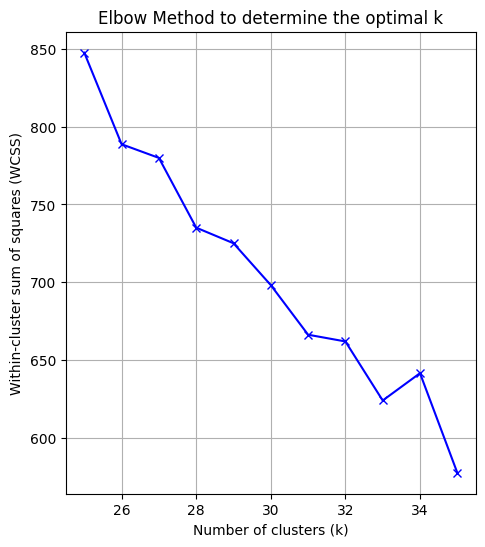

In [ ]:
# Plot 1: Elbow method

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(k_range, wcss_values, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method to determine the optimal k')
plt.grid(True)

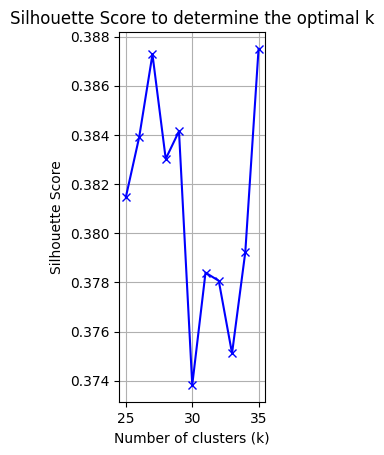

In [ ]:
# Plot 2: Silhouette score
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to determine the optimal k')
plt.grid(True)

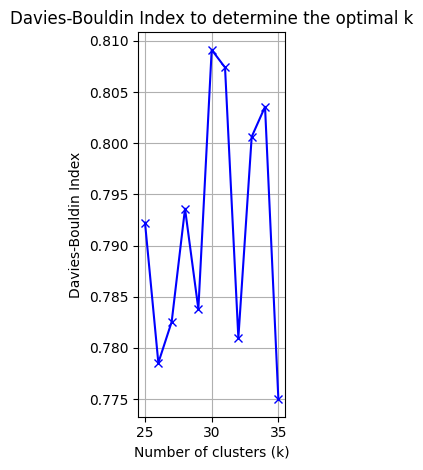

In [ ]:
# Plot 3: Davies-Bouldin index
plt.subplot(1, 3, 3)
plt.plot(k_range, davies_bouldin_indices, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index to determine the optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-29-b922b96d3c4c>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20c', optimal_k+10)


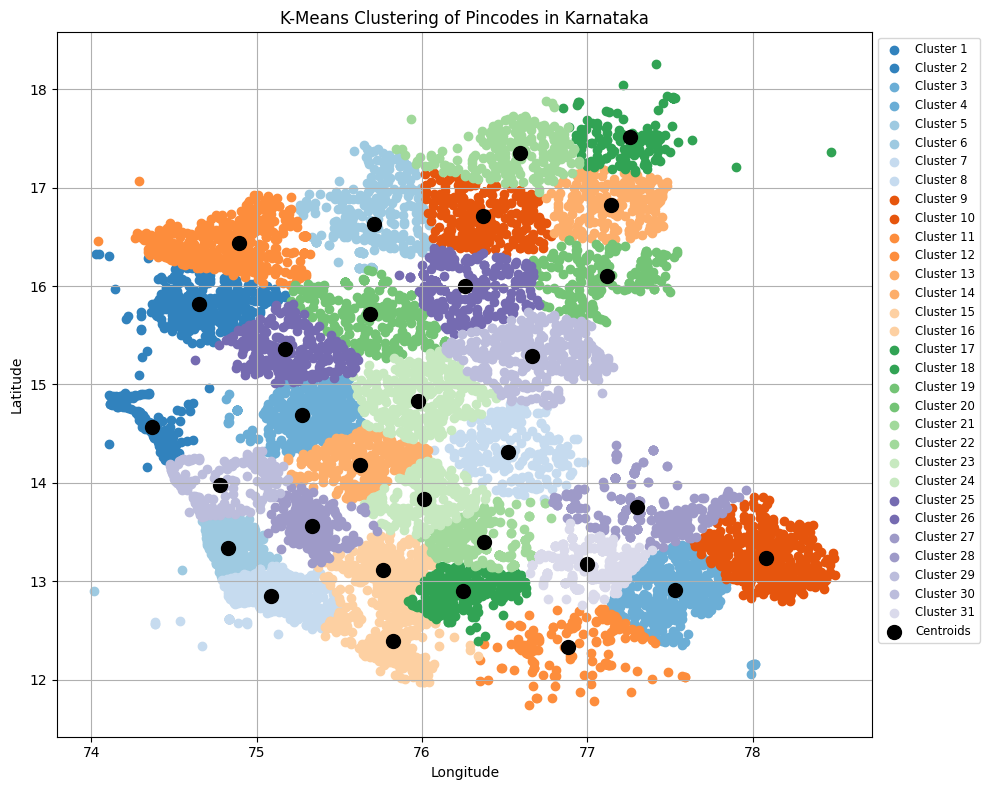

In [ ]:

optimal_k = 31  # Number of districts in Karnataka. Any other optimal value can also be chosen

centroids, labels, _, _, _ = kmeans(data_for_clustering, optimal_k)


plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap('tab20c', optimal_k+10)

for i in range(optimal_k):
    plt.scatter(data_for_clustering[labels == i, 0], data_for_clustering[labels == i, 1],
                color=colors(i), label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='o', label='Centroids')
plt.title('K-Means Clustering of Pincodes in Karnataka')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Adjust legend position and font size
plt.grid(True)
plt.tight_layout()
plt.show()
